## The Windy Gridworld Problem
This is a standard grid-world with one difference: a upward crosswind through the middle of the grid. In each state, you can take one of four actions {left, up, right, down} and that takes you to the corresponding cell (actions which would take you off the grid leave the state unchanged). In the middle region, the resultant states are shifted upward by a wind, the strength of which varies from column to column. The strength is indicated below the column. e.g. if you are one cell to the right of the goal, the action **left** takes you to the cell just above the goal. We will treat this as an undiscounted episodic task with rewards of -1 until the goal state is reached.

The code below uses Sarsas to learn the action-values with $\epsilon$ = 0.1, $\alpha$ = 0.5 and initial values of $Q(s,a) = 0$ for all s, a

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

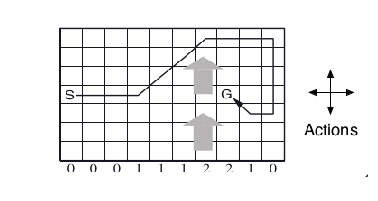

In [2]:
img = mpimg.imread('windy gridworld.png')
plt.axis('off')
plt.imshow(img)

In [3]:
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3

# Coordinates in (row, column) format
INITIAL_STATE = [3, 0]
FINAL_STATE = [3, 7]

WIDTH = 10
HEIGHT = 7
ACTION_COUNT = 4

In [4]:
class WindyGridworld:
    up_draft = {0:0, 1:0, 2:0, 3:1, 4:1, 5:1, 6:2, 7:2, 8:1, 9:0}
    pos = []
    
    def __init__(self):        
        self.reset()
        
    
    def step(self, action):
        """
        Takes the given action and returns a tuple (next_state, reward, done)
        """
        reward = 0
        done = self.is_final()
        
        if not done:   
            # Negative reward for all other transitions
            reward = -1
            displacement = self.up_draft[self.pos[1]]
            
            if action == LEFT:
                self.pos[1] = 0 if self.pos[1] == 0 else self.pos[1] - 1
            elif action == RIGHT:
                self.pos[1] = self.pos[1] if self.pos[1] == (WIDTH - 1) else self.pos[1] + 1
            elif action == UP:
                self.pos[0] = 0 if self.pos[0] == 0 else self.pos[0] - 1
            elif action == DOWN:
                self.pos[0] = self.pos[0] if self.pos[0] == (HEIGHT - 1) else self.pos[0] + 1      
                
            # Apply upward translation due to wind
            new_y = self.pos[0] - displacement
            self.pos[0] = 0 if new_y < 0 else new_y
        
        return np.copy(self.pos), reward, self.is_final()
    
    def reset(self):
        self.pos = [x for x in INITIAL_STATE]
        return np.copy(self.pos)
        
    def is_final(self):
        return self.pos[0] == FINAL_STATE[0] and self.pos[1] == FINAL_STATE[1]
    

In [5]:
def epoch_greedy(Q, state):
    qa = Q[state[0], state[1]]
    prob = np.random.rand(1)
    if prob > epsilon:
        # exploit (greedy)
        action_index = np.random.choice(np.flatnonzero(qa == qa.max()))
    else:
        # explore (random action)
        action_index = np.random.randint(0, ACTION_COUNT)
    
    return action_index

In [6]:
# Same initialization as in text
gamma = 1 # no discount
epsilon = 0.1
alpha = 0.5
Q = np.zeros((HEIGHT, WIDTH, ACTION_COUNT))
steps = 8000

env = WindyGridworld()
step = 0
episodes = 0
s = env.reset()
x, y = [], [] # For plotting

while step < steps:    
    # Select action using policy derived from Q (e-greedy)
    a = epoch_greedy(Q, s)
        
    # Take action and observe next state and reward
    s_, r, done = env.step(a)
    
    # Choose A' from S' using policy derived from Q (e-greedy)
    a_ = epoch_greedy(Q, s_)
    
    # Update
    if done:
        Q[s[0], s[1], a] = Q[s[0], s[1], a] + alpha * (r - Q[s[0], s[1], a])
    else:
        Q[s[0], s[1], a] = Q[s[0], s[1], a] + alpha * (r + gamma * Q[s_[0], s_[1], a_] - Q[s[0], s[1], a])
    
    s = s_
    step += 1
    
    if step % 100 == 0:
        x.append(step)
        y.append(episodes)
    
    # Episode over, reset environment
    if done:
        s = env.reset()
        episodes += 1

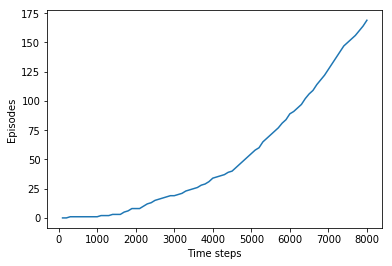

In [7]:
plt.plot(x, y)
plt.xlabel('Time steps')
plt.ylabel('Episodes')
plt.show()

As the results indicate, with more experience, the agent is able to solve the task faster (the slope is episodes/steps and a larger slope means better performance). The diagram at the top indicates the optimal trajectory which solves the problem in 15 steps.

## References
1. Richard S. Sutton, Andrew G. Barto (1998). Reinforcement Learning: An Introduction. MIT Press.